In [1]:
import sys
import joblib
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
sys.path.insert(0, '../utils/')
import keras_util as ku

## First iteration feature extraction visualisations.

In [3]:
data = sio.loadmat('plasticc-2018-preprocessed-mjd-flux-flux_err.mat')

In [4]:
x = data['x']
y = data['y']

In [5]:
x.shape

(7848, 352, 2)

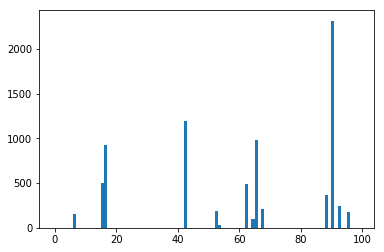

In [6]:
bins = [i for i in range(100)]
_,_,_ = plt.hist(y, bins=bins)

In [7]:
labels = np.unique(y)

In [8]:
print(labels, len(labels))

[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95] 14


## light curve feature extraction.

In [9]:
def preprocess_by_passband(X_raw, m_max=np.inf):
    X = X_raw.copy()

    wrong_units =  np.all(np.isnan(X[:, :, 1:-1])) | (np.nanmax(X[:, :, 1:-1], axis=1) > m_max)
    #X = X[~wrong_units, :, :]

    # Replace times w/ lags
    X[:, :, 0] = ku.times_to_lags(X[:, :, 0])

    means = np.atleast_2d(np.nanmean(X[:, :, 1:-1], axis=1))
    X[:, :, 1:-1] -= means[:,np.newaxis,:]

    scales = np.atleast_2d(np.nanstd(X[:, :, 1:-1], axis=1))
    X[:, :, 1:-1] /= scales[:,np.newaxis,:]

    # Drop_errors from input; only used as weights
    X = X[:, :, :-1]

    return X, means, scales, wrong_units

In [10]:
data = joblib.load(open('training.pkl', 'rb'))

In [11]:
passbands = np.array([i for i in range(6)])

In [12]:
xList = []
ids = []
for key in data.keys():
  mask = data[key]['detected'].astype('bool')
  fluxes = np.zeros((len(data[key]['flux']), 6))
  #print(mask.shape, np.sum(mask))
  #print(fluxes.shape)
  #print(data[key]['mjd'].shape)
  #print(data[key]['flux_err'].shape)
  for passband in passbands:
    t = np.where(data[key]['passband'] == passband)
    fluxes[t,passband] = data[key]['flux'][t]
  xList.append(np.c_[data[key]['mjd'][mask], \
                     fluxes[mask], \
                     data[key]['flux_err'][mask]])
  ids.append(key)
xf = pad_sequences(xList, value=np.nan, dtype='float', padding='post')
#xf, means, scales, wrong_units = preprocess_by_passband(xf)
xf[np.isnan(xf)] = 0.

In [13]:
d = np.genfromtxt('../data/training_set_metadata.csv', delimiter=',', skip_header=1)

In [14]:
hostgal_specz = d[:,6]

[[88]]
3.4451 None


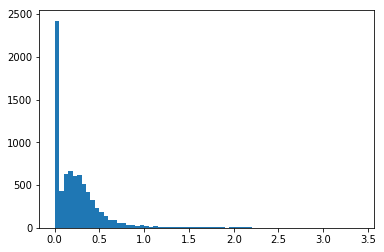

In [23]:
print(np.max(hostgal_specz), print(y[np.where(hostgal_specz == np.max(hostgal_specz))]))
bins = [i for i in np.arange(0, np.max(hostgal_specz), 0.05)]
plt.hist(hostgal_specz, bins=bins)
plt.show()

class 6
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Extragalactic :  False


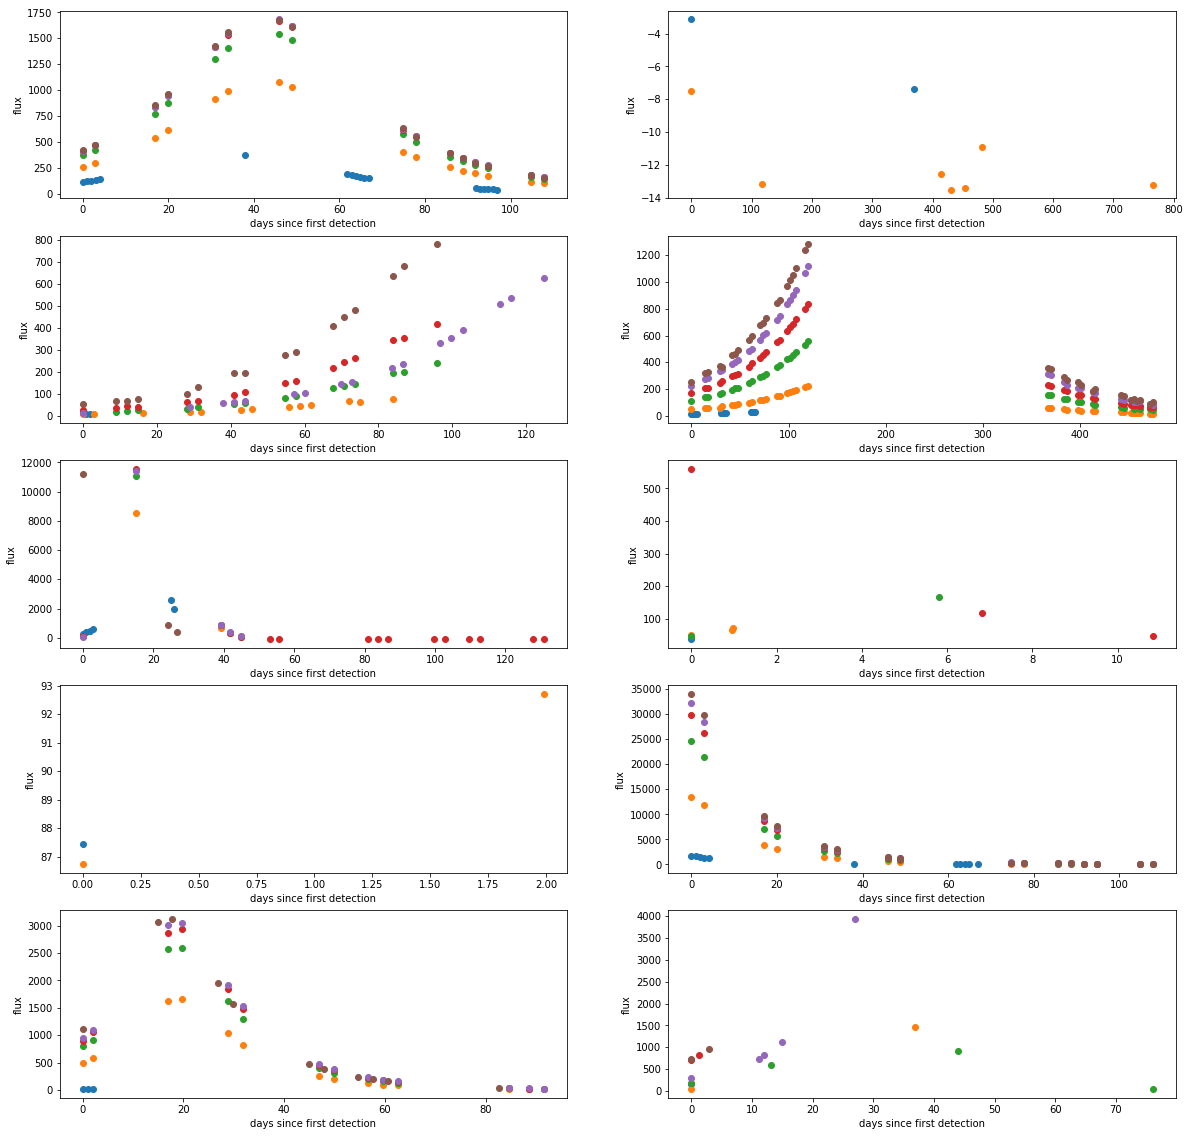

class 15
[0.5149 0.8237 0.1163 0.2914 0.2288 0.0258 0.3407 0.3048 0.4408 0.1172] Extragalactic :  True


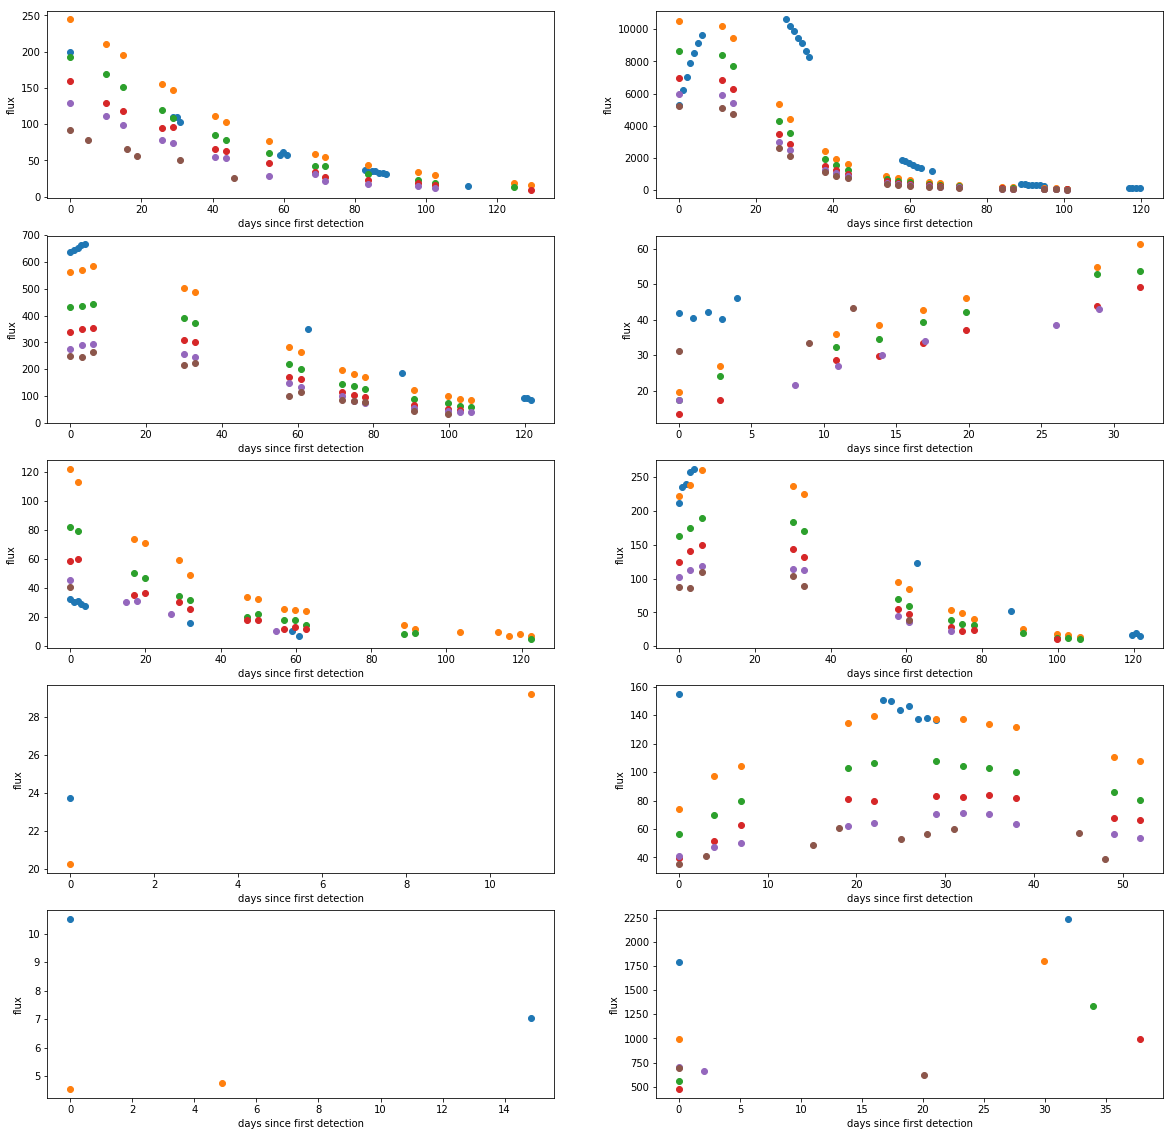

class 16
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Extragalactic :  False


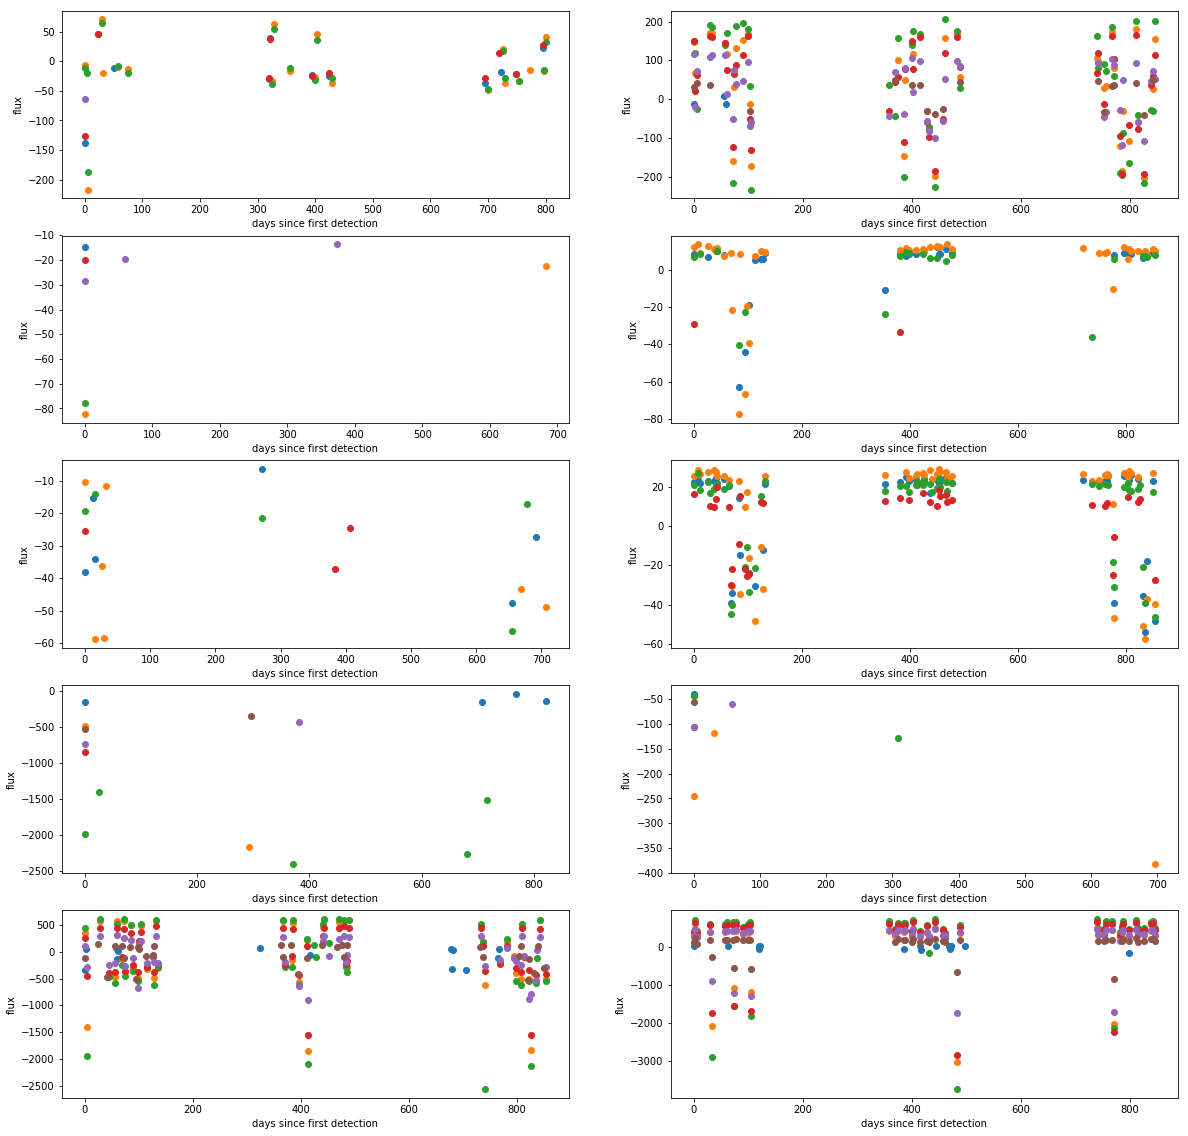

class 42
[0.232  0.6857 0.1695 0.236  0.161  0.0561 0.1197 0.1315 0.0826 0.1633] Extragalactic :  True


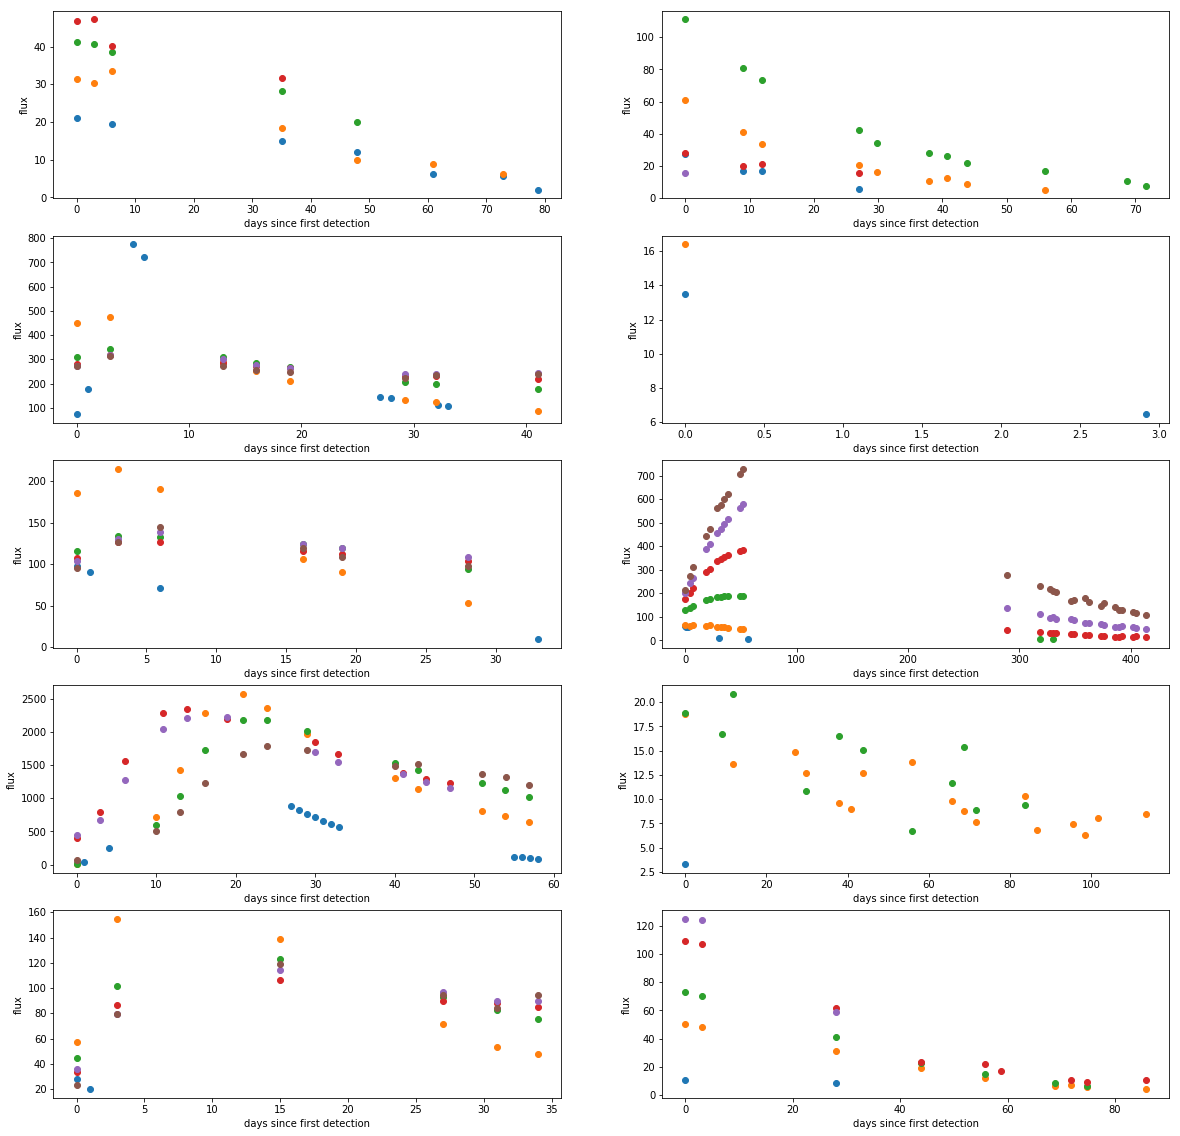

class 52
[0.1699 0.2207 0.0756 0.3434 0.1193 0.3391 0.3221 0.1407 0.2411 0.0853] Extragalactic :  True


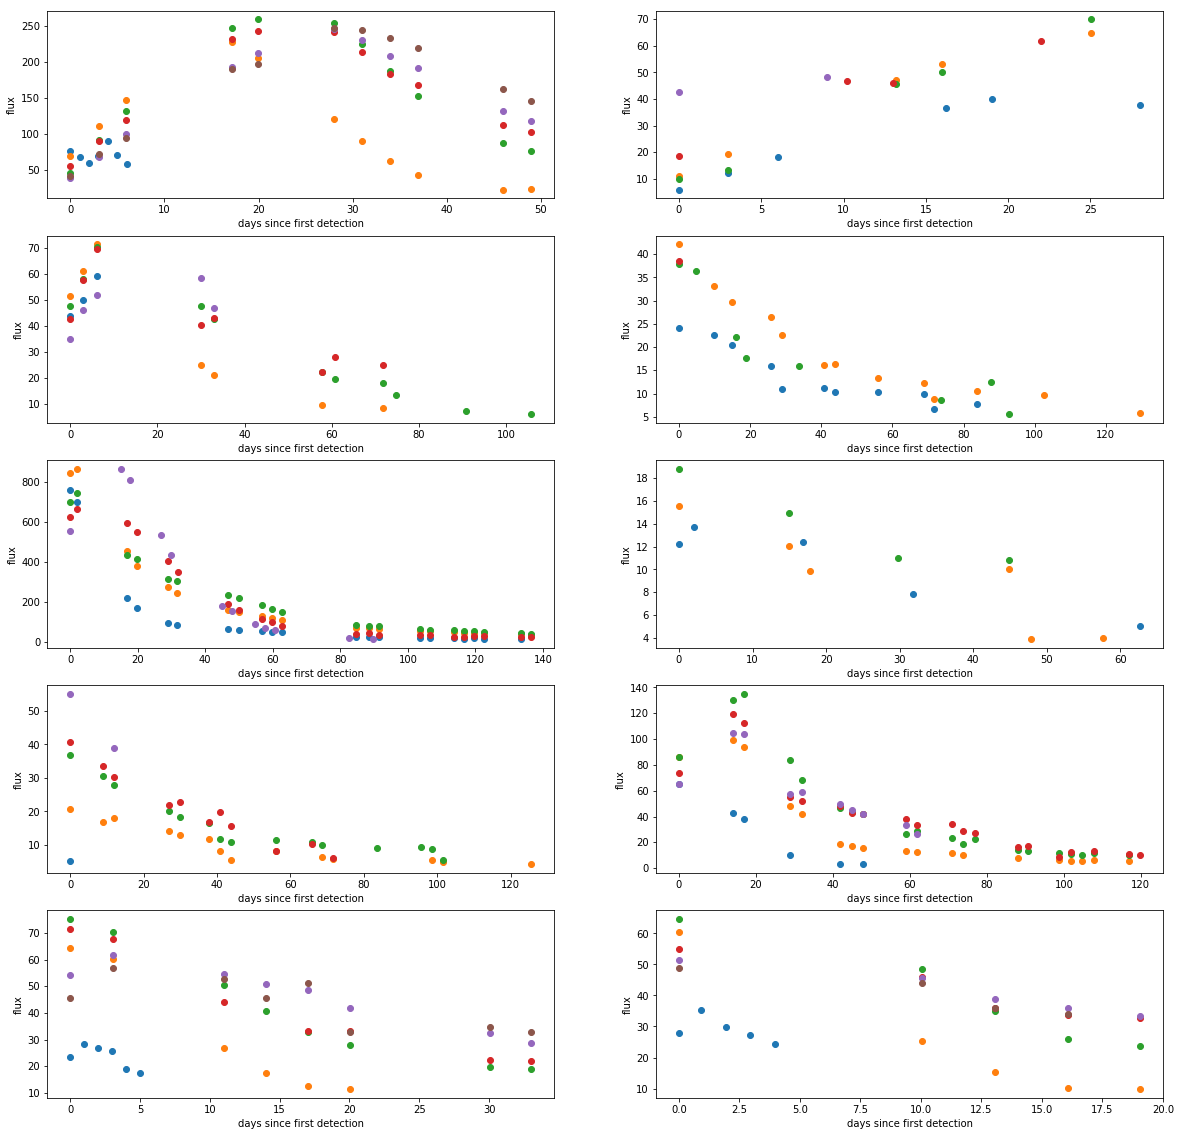

class 53
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Extragalactic :  False


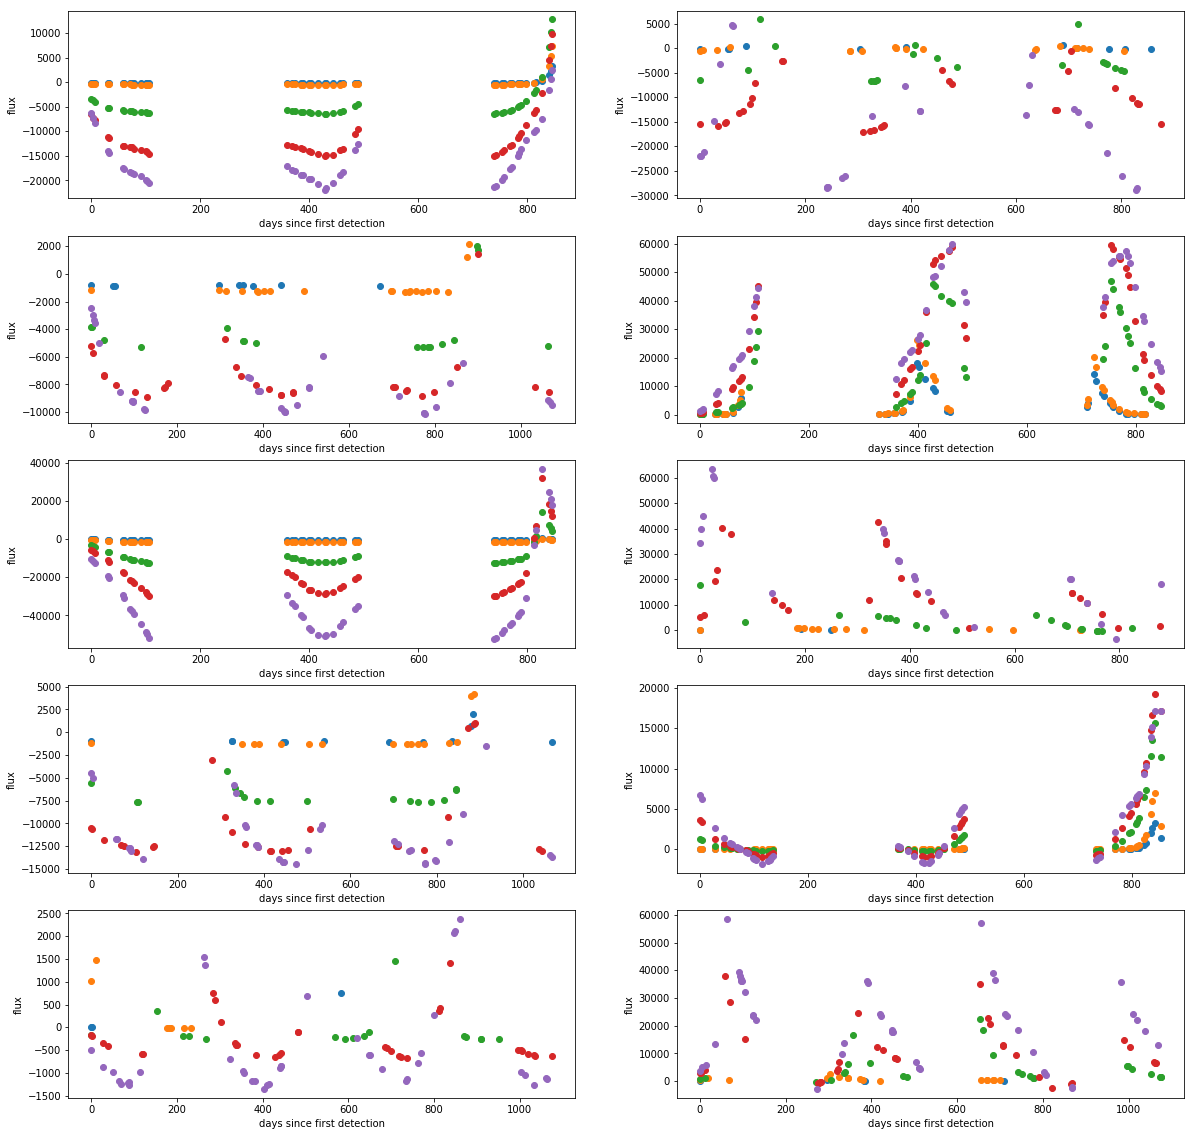

class 62
[0.1969 0.083  0.1415 0.3138 0.164  0.1706 0.1254 0.1549 0.1892 0.1135] Extragalactic :  True


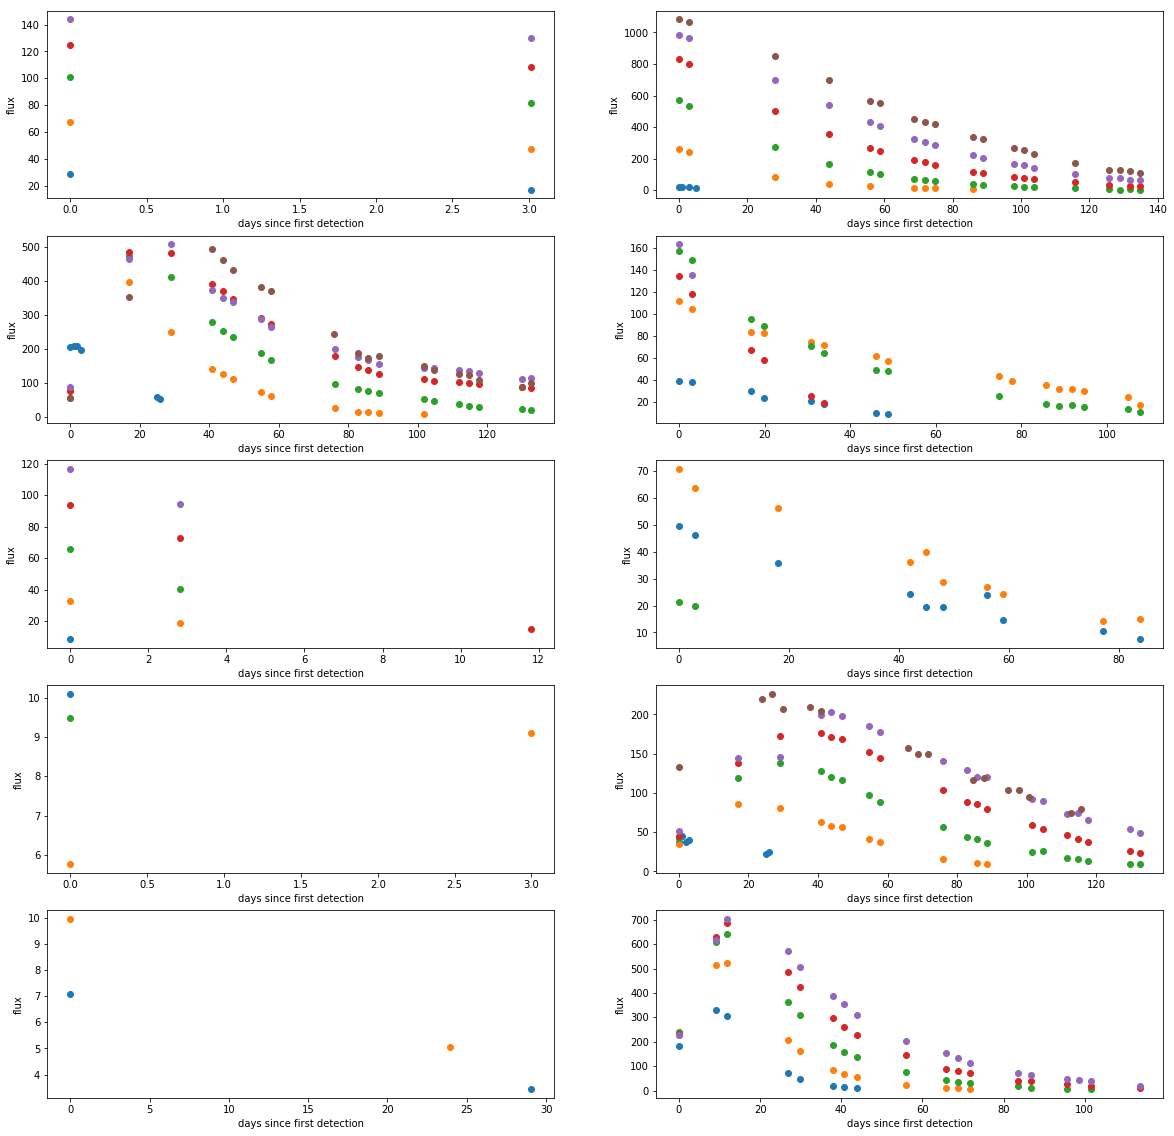

class 64
[0.1391 0.0809 0.0355 0.0383 0.0666 0.0441 0.1422 0.0549 0.0707 0.1845] Extragalactic :  True


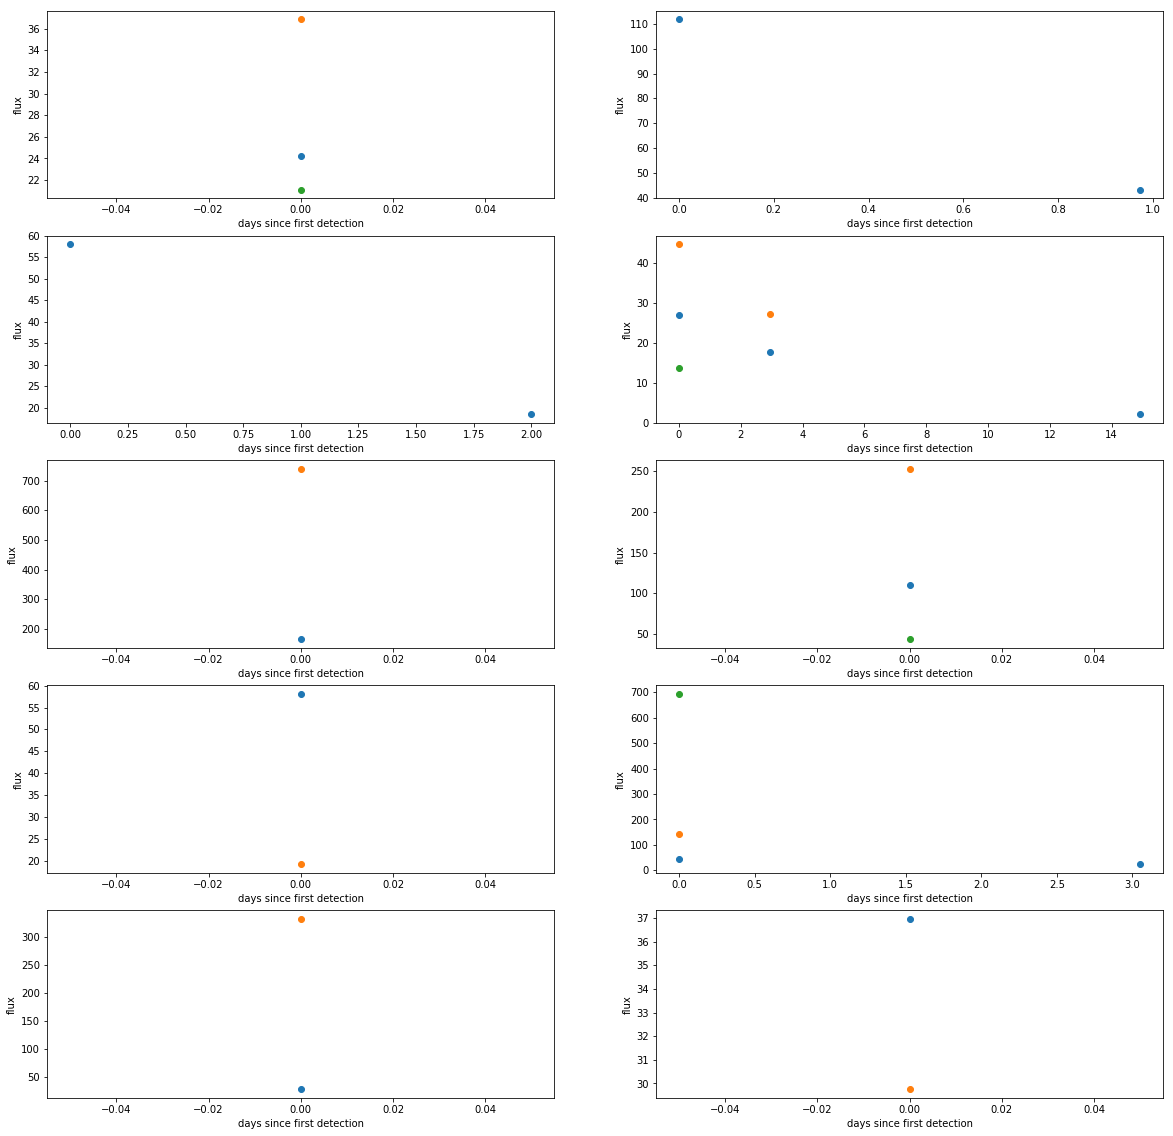

class 65
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Extragalactic :  False


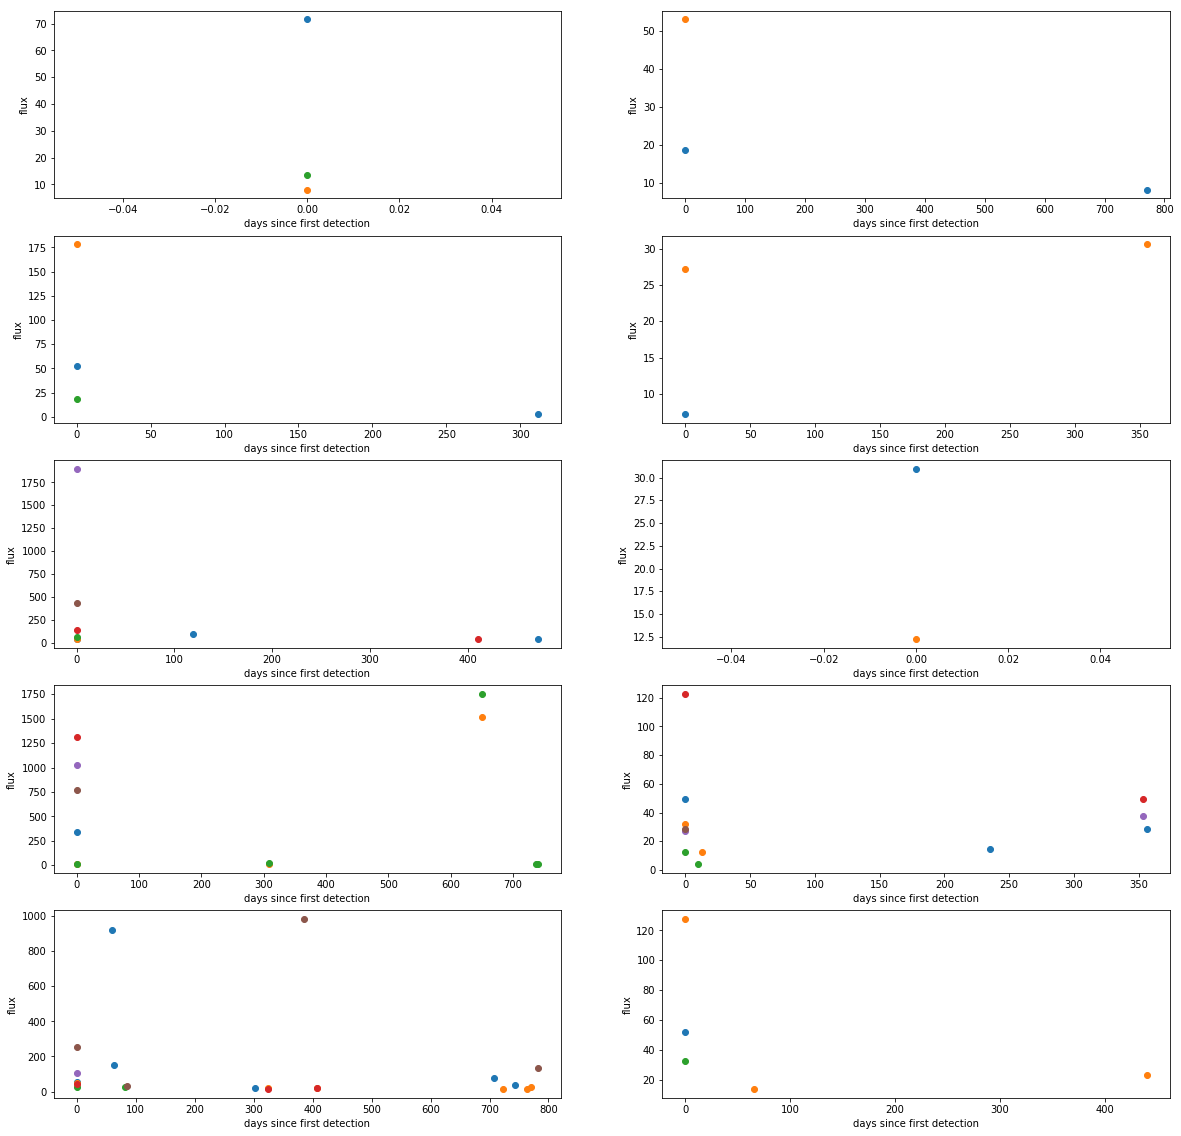

class 67
[0.1539 0.1069 0.2354 0.1743 0.2657 0.2517 0.1921 0.2821 0.3658 0.3009] Extragalactic :  True


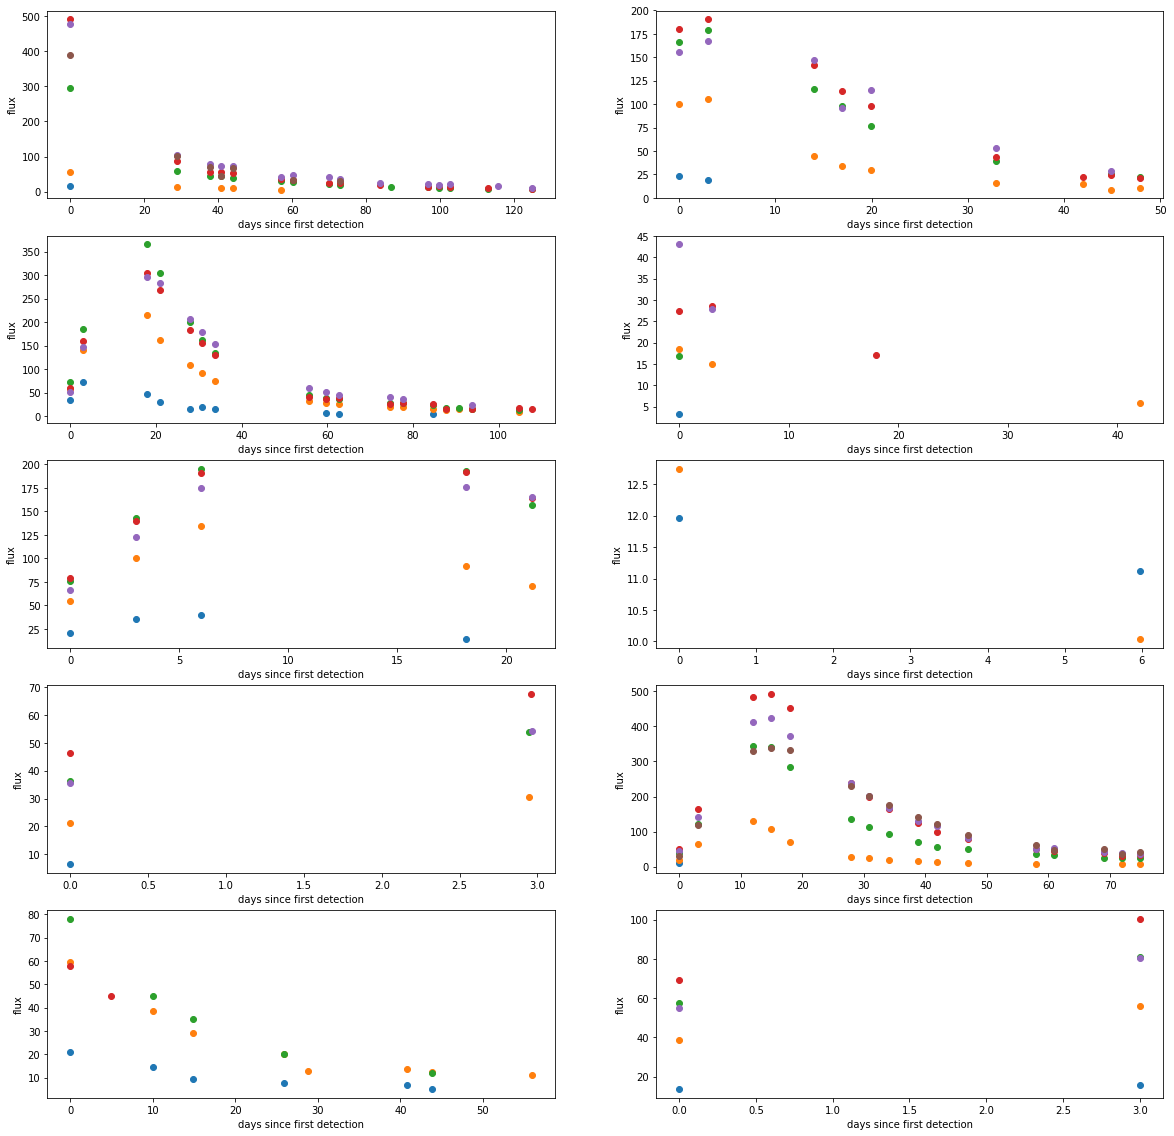

class 88
[1.8181 1.133  0.4833 0.133  3.4451 1.4031 0.6052 0.2882 0.3755 0.5869] Extragalactic :  True


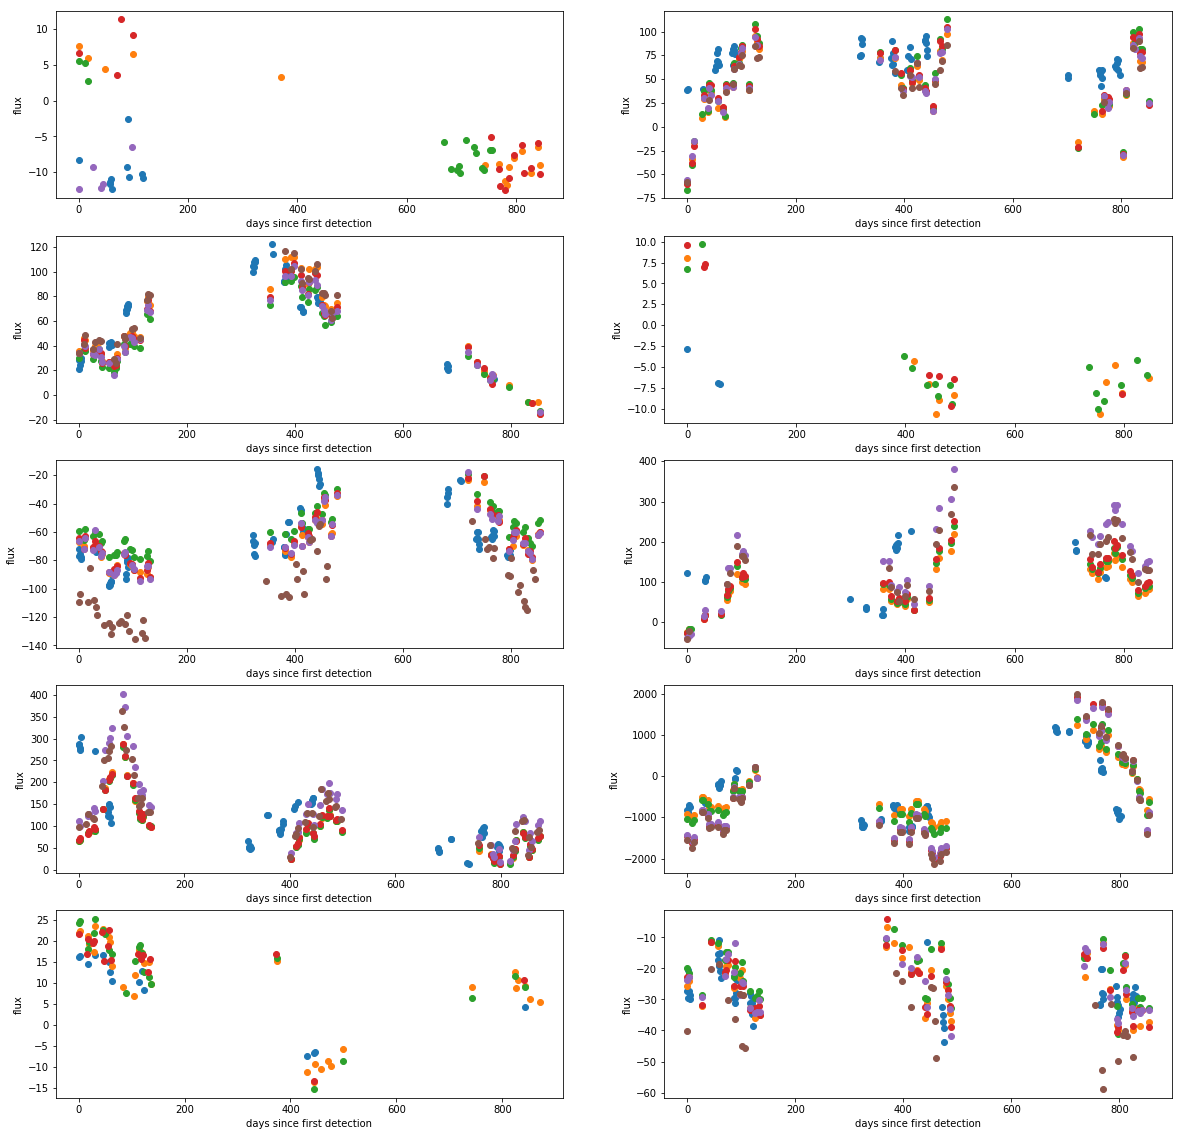

class 90
[0.3037 0.1934 0.1352 0.3088 0.1516 0.4541 0.2333 0.5919 0.3053 0.3201] Extragalactic :  True


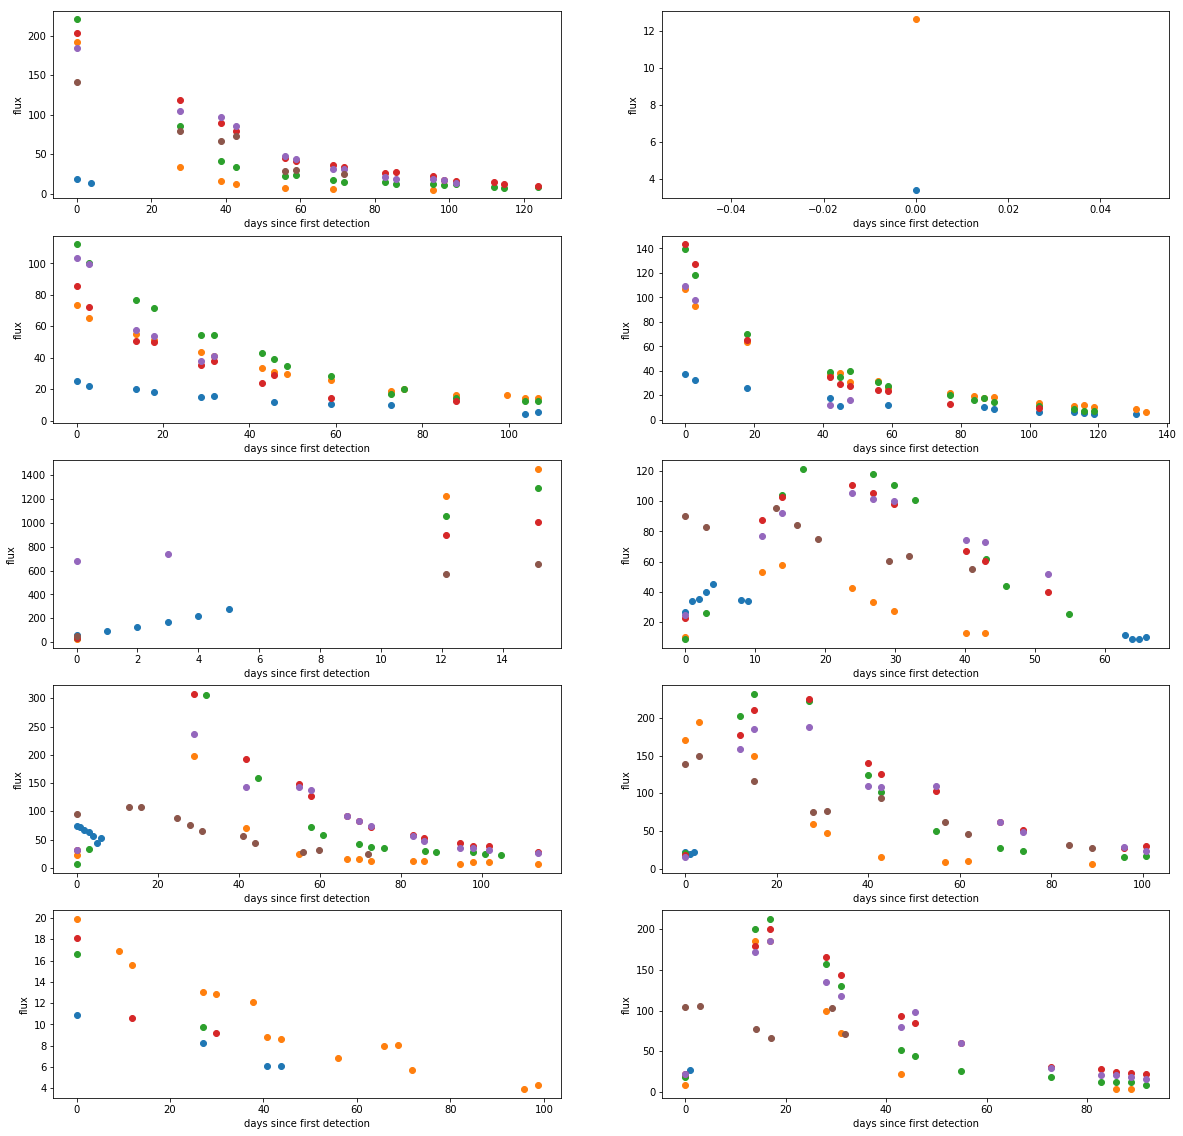

class 92
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Extragalactic :  False


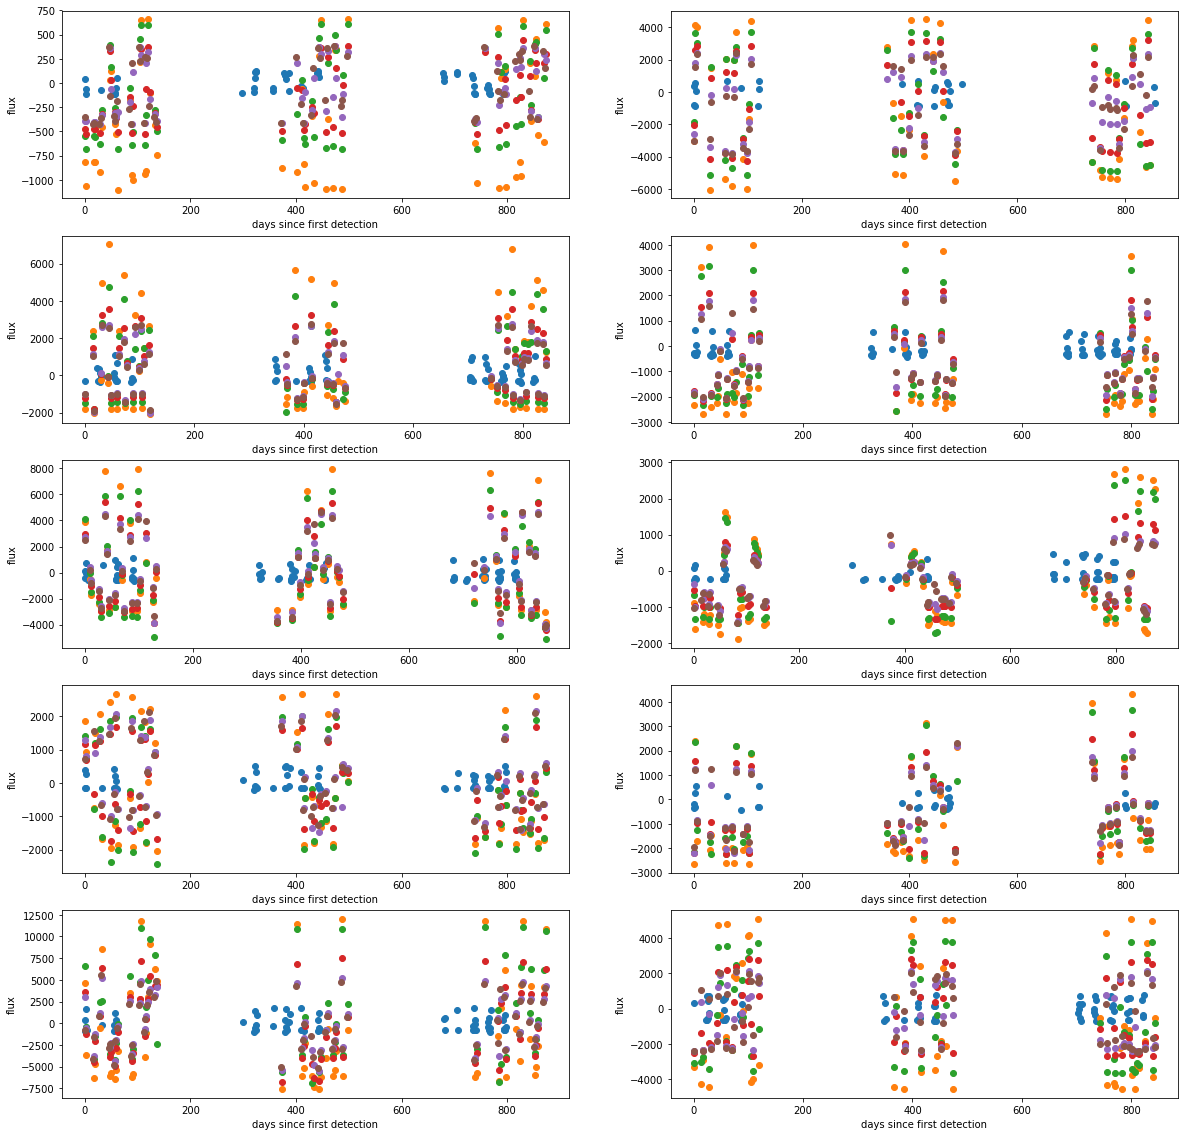

class 95
[1.9876 1.0833 1.1897 0.455  1.0133 1.8476 1.5989 0.8134 2.4303 1.3214] Extragalactic :  True


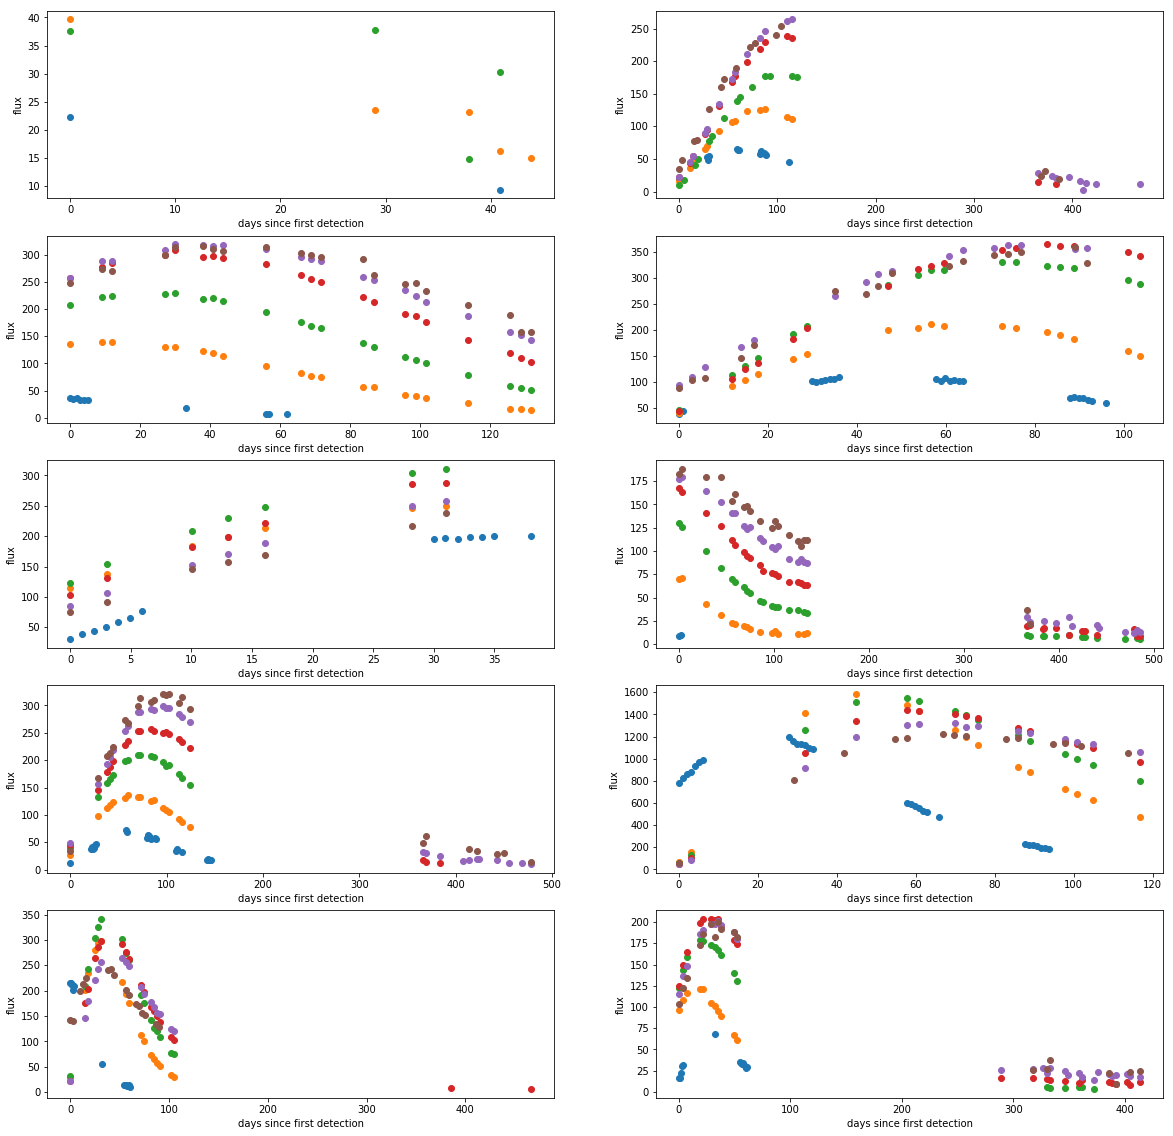

In [15]:
for i in range(len(labels)):
  _, axArray = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
  mask = np.where(y==labels[i])[0][:10]
  print('class %d' % (labels[i]))
  print(hostgal_specz[mask], 'Extragalactic : ', np.all(hostgal_specz[mask]>0))
  for j,m in enumerate(mask):
    for passband in passbands:
      zero_mask = np.where(xf[m,:,passband+1]!=0)
      #print(j%5, j%2, axArray[j%5, j%2])
      try:
        axArray[j%5, j%2].plot(xf[m,:,0][zero_mask] - np.min(xf[m,:,0][zero_mask]), \
                               xf[m,:,passband+1][zero_mask], 'o')
      except ValueError:
        continue
    axArray[j%5, j%2].set_xlabel('days since first detection')
    axArray[j%5, j%2].set_ylabel('flux')
  plt.show()

In [16]:
xf.shape

(7848, 352, 8)

## Lets see if the coordinates are realistic
Take the first 10 examples from class 53 which looks like a periodic variable to me and class 15 which looks like a supernova.  If the dataset is based in reality then I would expect class 53 to be coincident with stellar objects in the 3pi all sky image and class 15 to lie close to galaxies.

In [17]:
import matplotlib.image as mpimg 

[[149.414062   3.433834]
 [150.117188   3.732834]
 [149.414062   1.940072]
 [ 34.277344  -5.079716]
 [119.707031 -17.270004]
 [313.066406 -29.313198]
 [162.914444 -55.299438]
 [213.483414 -50.67416 ]
 [168.046875 -41.610443]
 [117.597656 -29.313198]]


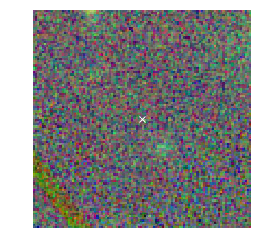

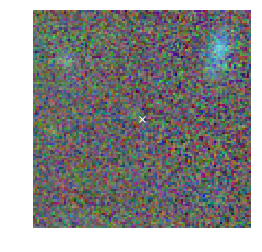

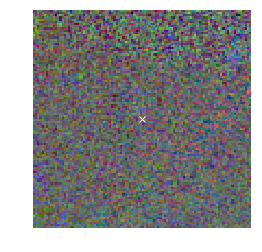

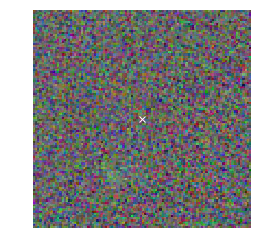

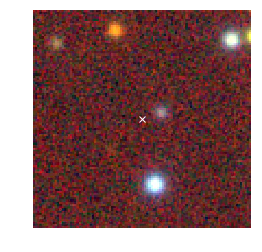

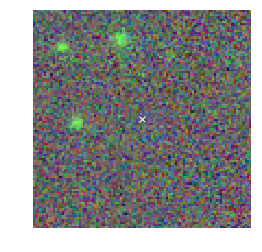

Object < -30 Dec :  [162.914444 -55.299438]
Object < -30 Dec :  [213.483414 -50.67416 ]
Object < -30 Dec :  [168.046875 -41.610443]


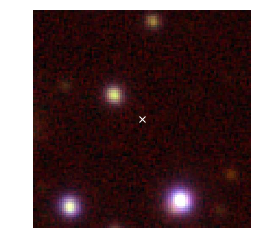

In [18]:
class_mask = np.where(y==53)[0]
print(d[class_mask[:10]][:,1:3])
for i in range(10):
  try:
    img = mpimg.imread('/Users/dwright/Desktop/ps1_cutouts/%s%s.jpeg'%(str(d[class_mask[i]][1]), str(d[class_mask[i]][2])))
    midpoint = int(img.shape[0] / 2.)
    plt.imshow(img)
    plt.plot(midpoint,midpoint,'wx')
    plt.axis('off')
    plt.show()
  except FileNotFoundError:
    print('Object < -30 Dec : ', d[class_mask[i]][1:3])

[[152.050781   3.284369]
 [ 53.261719 -27.615883]
 [347.84671  -64.760857]
 [351.299988 -62.3204  ]
 [151.523438   3.134927]
 [ 51.855469 -26.276812]
 [148.710938   2.836105]
 [148.886719   2.686724]
 [177.539062 -18.997131]
 [200.566406 -15.404094]]


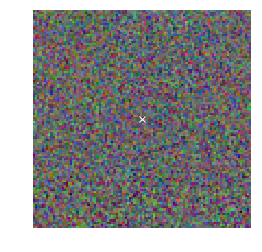

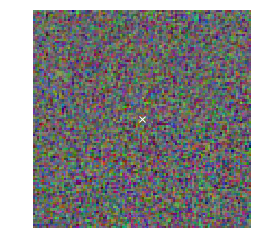

Object < -30 Dec :  [347.84671  -64.760857]
Object < -30 Dec :  [351.299988 -62.3204  ]


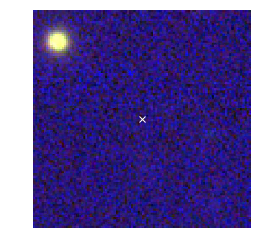

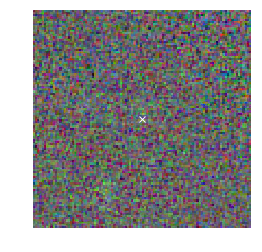

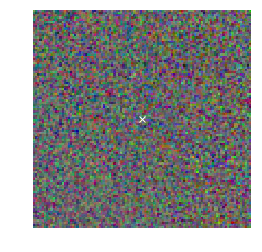

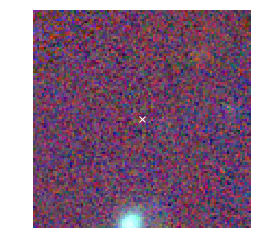

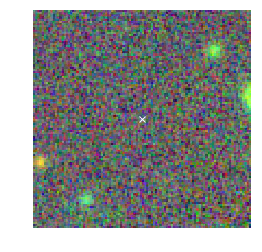

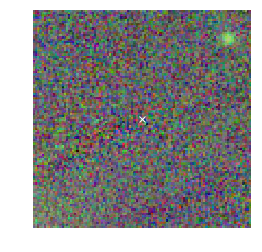

In [19]:
class_mask = np.where(y==15)[0]
print(d[class_mask[:10]][:,1:3])
for i in range(10):
  try:
    img = mpimg.imread('/Users/dwright/Desktop/ps1_cutouts/%s%s.jpeg'%(str(d[class_mask[i]][1]), str(d[class_mask[i]][2])))
    midpoint = int(img.shape[0] / 2.)
    plt.imshow(img)
    plt.plot(midpoint,midpoint,'wx')
    plt.axis('off')
    plt.show()
  except FileNotFoundError:
    print('Object < -30 Dec : ', d[class_mask[i]][1:3])